In [1]:
include("astrobee_se3_script.jl")
using Plots
using JLD2, FileIO
using HDF5
using Keras
using Polynomials
using Statistics
using StatsPlots


┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /home/somrita/.julia/packages/CUDAdrv/3EzC1/src/CUDAdrv.jl:69


# Helper functions

## Main GuSTO function

In [2]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true, Xp = [], Up = [])
    
    if (Xp == [] && Up == [])
        Xp,Up = initialize_trajectory(model, N)
    elseif Up == []
        println("GuSTO X has been warm-started.")
        Up = zeros(model.u_dim, N-1)
    else
        if verbose
            println("GuSTO has been warm-started.")
        end
    end
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 0
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, it, X_all, U_all
end

solve_gusto (generic function with 4 methods)

## Function to check if inside obstacle

In [3]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    for obs in model.poly_obstacles
        center = obs.c
        dx = obs.dx
        dy = obs.dy
        dz = obs.dz
        x_max = center[1]+dx
        y_max = center[2]+dy
        z_max = center[3]+dz
        x_min = center[1]-dx
        y_min = center[2]-dy
        z_min = center[3]-dz
        if (x[1]<= x_max && x[1] >= x_min && 
            x[2]<= y_max && x[2] >= y_min &&
            x[3]<= z_max && x[3] >= z_min)
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

# Plotting functions

In [4]:
function plot_env_and_trajs_three_comp(model, X_all, labls = :None)
    N = length(X_all)
    if N == 3
        labls = ["GuSTO solution", "NN prediction", "GuSTO warm-started"]
    elseif labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    idx = [1,2]
#     local fig
#     fig = plot(framestyle = :box)
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            r = plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             @show r.color
        else
            plot!(X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.4, st_pt[2]+0.4, text("\$x_{init}\$", 22, :black, :left)), 
            (end_pt[1]+0.4, end_pt[2]-0.4, text("\$x_{final}\$", 22, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        buf = 0.2
        r1 = r1-buf
        r2 = r2-buf
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(legend = :best, legendfontsize=10)
    plot!(size=(550,550))
    xlabel!("x", guidefontsize = 16)
#     ylabel!("y", guidefontsize = 13)
    annotate!([(-1,5,Plots.text("y",16))])
    plot!(tickfontsize = 12)
#     return fig
end

plot_env_and_trajs_three_comp (generic function with 2 methods)

## Reading and writing to files

In [5]:
function getXYValid(filename)
    f = h5open(filename,"r")
    X_valid_norm = read(f["X_valid_norm"])
    Y_valid_norm = read(f["Y_valid_norm"])
    close(f)
    return (X_valid_norm, Y_valid_norm) 
end


getXYValid (generic function with 1 method)

In [6]:
function getDataParamsFromHDF5Combo(filename)
    f = h5open(filename,"r")
    xMin = read(f["xMin"])
    yMin = read(f["yMin"])
    xRange = read(f["xRange"])
    yRange = read(f["yRange"])
    close(f)
    return (xMin, yMin, xRange, yRange) 
end

getDataParamsFromHDF5Combo (generic function with 1 method)

## Get model on which data was collected and training done

In [7]:
function getModelWithTwoPolyObsOneAtCorner()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]

    obstacles = []
    # obs = [[0.0,0.0,0.0], 6.0]
    # push!(obstacles, obs)
    model.obstacles = obstacles

    poly_obstacles = []
    obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
    push!(poly_obstacles, obs)
    obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
    push!(poly_obstacles, obs)
    model.poly_obstacles = poly_obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 5.0 # TODO CHANGED was 2.0
    
    return model
end

getModelWithTwoPolyObsOneAtCorner (generic function with 1 method)

In [8]:
function findTrueGuSTOSolution(x_init, x_final, model = :None, verbose = false, Xinit = [], Uinit = [])
    N = 50
    MAX_ITERATIONS_NB = 200
    
    if model == :None
        println("No model supplied. Using spheres model.")
        model = getModelWithCornerSpheres()
    end
    
    isConverged = false
    X_all = []
    U_all = []
    numIter = 0

    problemNumber = 0

    train_input_collected = Array{Float64}(undef,0,26)
    train_output_collected = Array{Float64}(undef,0,944)

    if isInsideObstacle(x_init, model)
        println("x_init is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if isInsideObstacle(x_final, model)
        println("x_final is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if norm(x_final[1:3] - x_init[1:3])<1.0
        println("x_init and x_final too close. Not valid.")
        return model, isConverged, X_all, U_all
    end


    model.x_init = x_init
    model.x_final = x_final
    
    if verbose
        println("Starting to solve GuSTO")
    end
    try
        isConverged, numIter, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, verbose, Xinit, Uinit)
    catch e
        isConverged = false
        println("$e")
    end
    if verbose
        println("Converged: $isConverged")
    end

    return model, isConverged, numIter, X_all, U_all
end



findTrueGuSTOSolution (generic function with 5 methods)

## NN helper functions

In [9]:
function recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    output_coeffs = (NN_output.*yRange)+yMin    
    return output_coeffs
end

recoverCoeffsfromNNOutput (generic function with 1 method)

In [10]:
function recoverXUfromCoeffs(coeffs)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    X_soln = zeros(x_dim, N)
    U_soln = zeros(u_dim, N-1)
    
    for dim = 1:x_dim
        cf_this = coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_array)
        X_soln[dim, :] = this_poly
    end
    
    for dim = 1:u_dim
        cf_this = coeffs[(x_dim*num_coeffs + (dim-1)*num_coeffs + 1): (x_dim*num_coeffs + dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        U_soln[dim, :] = this_poly
    end
    
    return X_soln, U_soln
end

recoverXUfromCoeffs (generic function with 1 method)

In [11]:
function recoverXUfromNNOutput(NN_output, yMin, yRange)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    X_soln, U_soln = recoverXUfromCoeffs(outputCoeffs)
end

recoverXUfromNNOutput (generic function with 1 method)

In [12]:
function createNNInput(x_init, x_final, xMin, xRange)
    # x_init and x_goal need to be of size 13
    NN_input = hcat([x_init', x_final']...)'
    NN_input = (NN_input-xMin)./xRange
    return NN_input
end

createNNInput (generic function with 1 method)

In [13]:
function getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin, yMin, xRange, yRange)  
end

getNNStructureCombo (generic function with 1 method)

In [14]:
function getNNPredictionCombo(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin, yMin, xRange, yRange) = getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin, xRange)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin, yRange)
    return (X_soln, U_soln)
end

getNNPredictionCombo (generic function with 1 method)

# Get GuSTO to converge in under 5 iterations

In [15]:
filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
row = 3
@show row
# For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
x_v_norm = X_valid_norm[row,:] # size 26
# First convert to X_valid
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:13]
x_final = x_v[14:26]
@show x_init
@show x_final
    
model = getModelWithTwoPolyObsOneAtCorner()
# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, true)
gusto_solve_time = (time_ns() - time_start)/10^9
@show isConverged
@show numIter
@show gusto_solve_time

row = 3
x_init = [6.66667, 4.44444, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
x_final = [5.55556, 7.77778, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Starting to solve GuSTO
-----------
Iteration 0
metric=0.0
-----------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

x(k) - x(k-1) = 0.34792955357955435
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 1
metric=3.8409964425637164
-----------
Accept solution.
x(k) - x(k-1) = 0.03277308990554384
Parameters:
omega=1.0
delta=1000.0
Converged
Converged: true
isConverged = true
numIter = 2
gusto_solve_time = 39.281306432


39.281306432

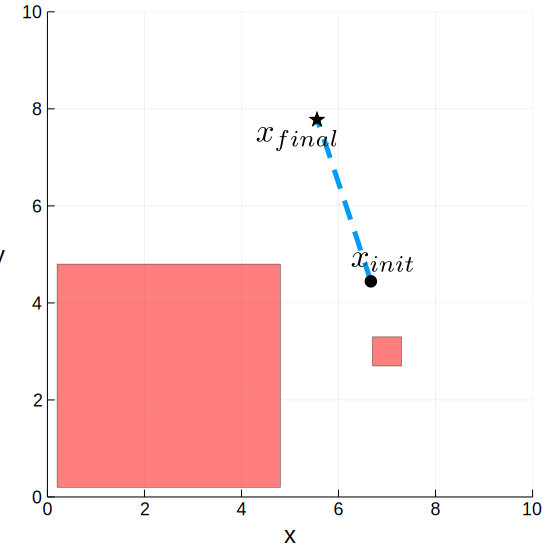

In [16]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]])

In [17]:
paramsFileName = "PolyComboParams.h5"
row = 836
@show row
# For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
x_v_norm = X_valid_norm[row,:] # size 26
# First convert to X_valid
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:13]
x_final = x_v[14:26]
@show x_init
@show x_final
    
model = getModelWithTwoPolyObsOneAtCorner()
# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, true)
gusto_solve_time = (time_ns() - time_start)/10^9
@show isConverged
@show numIter
@show gusto_solve_time

row = 836
x_init = [0.9375, 5.8125, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
x_final = [9.5, 1.0625, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Starting to solve GuSTO
-----------
Iteration 0
metric=0.0
-----------
x(k) - x(k-1) = 1.662634942273308
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 1
metric=18.082569201646216
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
x(k) - x(k-1) = 0.46265196836287936
Parameters:
omega=5.0
delta=1000.0
-----------
Iteration 2
metric=4.862909486199058
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
x(k) - x(k-1) = 0.5709086642947057
Parameters:
omega=25.0
delta=1000.0
-----------
Iteration 3
metric=7.883729913123537
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
x(k) - x(k-1) = 1.565652274193062
Parameters:
omega=125.0
delta=1000.0
-----------
Iteration 4
metric=16.660540826942782
---

6.026795581

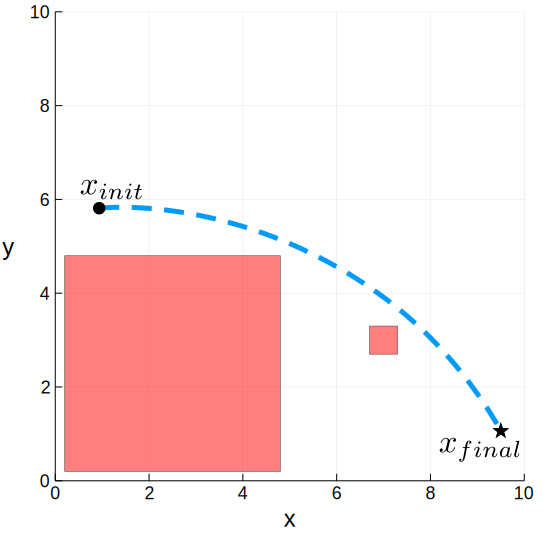

In [18]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]])

# Compare cold start and warm start GuSTO performance

### Collect the iteration number and times for each

In [20]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
# @show size(X_valid_norm)
# @show size(Y_valid_norm)

cold_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: cold_start_data[row,:] = [converged?, num_iter, solve_time]

warm_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: warm_start_data[row,:] = [converged?, num_iter, solve_time]

NN_run_data = zeros(size(X_valid_norm,1),1)
# NOTE: NN_run_data[row,:] = NN_solve_time

for row in 1:size(X_valid_norm,1)
# for row in 3:4
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    model = getModelWithTwoPolyObsOneAtCorner()

    # GuSTO solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, false)
    gusto_solve_time = (time_ns() - time_start)/10^9
    cold_start_data[row,:]= [isConverged, numIter, gusto_solve_time]
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    NN_run_data[row,1]= NN_solve_time
    @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    warm_start_data[row,:]= [isConverged, numIter_warm, gusto_warm_solve_time]
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")
    
    println("")

#     plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])

    
    
    
#     # NN prediction time and trajectory
#     NN_coeffs = getNNCoeffsCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
# #     @show size(NN_coeffs)

#     # For the Y_valid_norm, these are 95 coefficients
#     y_v_norm = Y_valid_norm[row,:] # size 95
#     # First convert to Y_valid
#     (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
#     true_coeffs = y_v_norm.*yRange + yMin
# #     @show size(true_coeffs)

#     for dim in 1:(x_dim+u_dim)
#         true_cf_this = true_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         NN_cf_this = NN_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         true_coeffs_matrix[row,dim,:] = true_cf_this
#         NN_coeffs_matrix[row,dim,:] = NN_cf_this
#     end
    if mod(row,10) == 0
        @save "coldstartwarmstartdataAdjusted2.jld2" cold_start_data warm_start_data NN_run_data
        println("Intermediate save")
        println("")
    end
end
@save "coldstartwarmstartdataAdjusted2.jld2" cold_start_data warm_start_data NN_run_data
print("All GuSTO warm start, cold start and NN run times are saved")            

row = 1
GuSTO solve time = 1.500322646 (2 iterations)
NN_solve_time = 3.319836423
GuSTO warm started solve time = 1.783910919 (3 iterations)

row = 2
GuSTO solve time = 1.079936015 (2 iterations)
NN_solve_time = 0.002585024
GuSTO warm started solve time = 2.583042681 (4 iterations)

row = 3
GuSTO solve time = 1.135205756 (2 iterations)
NN_solve_time = 0.002667959
GuSTO warm started solve time = 1.18452181 (2 iterations)

row = 4
GuSTO solve time = 1.627885102 (2 iterations)
NN_solve_time = 0.002167347
GuSTO warm started solve time = 1.169180683 (2 iterations)

row = 5
GuSTO solve time = 1.040895728 (2 iterations)
NN_solve_time = 0.002026578
GuSTO warm started solve time = 1.149346675 (2 iterations)

row = 6
GuSTO solve time = 1.321312662 (2 iterations)
NN_solve_time = 0.00198691
GuSTO warm started solve time = 1.208468343 (2 iterations)

row = 7
GuSTO solve time = 1.058476358 (2 iterations)
NN_solve_time = 0.002473045
GuSTO warm started solve time = 1.113857617 (2 iterations)

row = 8


GuSTO solve time = 2.277344945 (4 iterations)
NN_solve_time = 0.001994421
GuSTO warm started solve time = 10.654413663 (17 iterations)

row = 115
GuSTO solve time = 1.056273584 (2 iterations)
NN_solve_time = 0.003457958
GuSTO warm started solve time = 1.089541742 (2 iterations)

row = 116
GuSTO solve time = 5.545038114 (9 iterations)
NN_solve_time = 0.001976737
GuSTO warm started solve time = 21.911013878 (34 iterations)

row = 117
GuSTO solve time = 1.17077313 (2 iterations)
NN_solve_time = 0.002085986
GuSTO warm started solve time = 1.526781 (2 iterations)

row = 118
GuSTO solve time = 1.114346065 (2 iterations)
NN_solve_time = 0.002104419
GuSTO warm started solve time = 1.152254937 (2 iterations)

row = 119
GuSTO solve time = 4.032656061 (7 iterations)
NN_solve_time = 0.001951504
GuSTO warm started solve time = 1.217629529 (2 iterations)

row = 120
GuSTO solve time = 3.734123511 (6 iterations)
NN_solve_time = 0.002090366
GuSTO warm started solve time = 2.309254713 (4 iterations)

In

GuSTO warm started solve time = 3.4880739 (6 iterations)

Intermediate save

row = 171
GuSTO solve time = 1.410809264 (2 iterations)
NN_solve_time = 0.001967553
GuSTO warm started solve time = 1.25298197 (2 iterations)

row = 172
GuSTO solve time = 1.093481457 (2 iterations)
NN_solve_time = 0.001966733
GuSTO warm started solve time = 1.166169587 (2 iterations)

row = 173
GuSTO solve time = 4.574367326 (7 iterations)
NN_solve_time = 0.001944042
GuSTO warm started solve time = 3.176488801 (5 iterations)

row = 174
GuSTO solve time = 1.615320689 (3 iterations)
NN_solve_time = 0.001937011
GuSTO warm started solve time = 1.664085851 (3 iterations)

row = 175
GuSTO solve time = 1.044032736 (2 iterations)
NN_solve_time = 0.001941894
GuSTO warm started solve time = 1.370412554 (2 iterations)

row = 176
GuSTO solve time = 1.089718589 (2 iterations)
NN_solve_time = 0.002008649
GuSTO warm started solve time = 1.097965723 (2 iterations)

row = 177
GuSTO solve time = 1.660072919 (3 iterations)
NN_s

GuSTO warm started solve time = 1.387439949 (2 iterations)

row = 283
GuSTO solve time = 1.07453753 (2 iterations)
NN_solve_time = 0.0024858
GuSTO warm started solve time = 1.13130275 (2 iterations)

row = 284
GuSTO solve time = 12.592039526 (20 iterations)
NN_solve_time = 0.002193765
GuSTO warm started solve time = 8.519570784 (14 iterations)

row = 285
GuSTO solve time = 1.141960769 (2 iterations)
NN_solve_time = 0.002064339
GuSTO warm started solve time = 1.16364463 (2 iterations)

row = 286
GuSTO solve time = 4.008414127 (6 iterations)
NN_solve_time = 0.002066178
GuSTO warm started solve time = 2.271081765 (4 iterations)

row = 287
GuSTO solve time = 8.000894444 (13 iterations)
NN_solve_time = 0.003372159
GuSTO warm started solve time = 2.233087911 (4 iterations)

row = 288
GuSTO solve time = 4.172814257 (6 iterations)
NN_solve_time = 0.002139812
GuSTO warm started solve time = 3.074396726 (5 iterations)

row = 289
GuSTO solve time = 1.099825404 (2 iterations)
NN_solve_time = 0.010

GuSTO warm started solve time = 1.929502879 (3 iterations)

row = 395
GuSTO solve time = 1.128040127 (2 iterations)
NN_solve_time = 0.002112776
GuSTO warm started solve time = 1.143810828 (2 iterations)

row = 396
GuSTO solve time = 1.60537316 (3 iterations)
NN_solve_time = 0.002619518
GuSTO warm started solve time = 2.01758558 (3 iterations)

row = 397
GuSTO solve time = 2.849472443 (5 iterations)
NN_solve_time = 0.002325583
GuSTO warm started solve time = 1.380828247 (2 iterations)

row = 398
GuSTO solve time = 1.220076084 (2 iterations)
NN_solve_time = 0.002241568
GuSTO warm started solve time = 1.134599427 (2 iterations)

row = 399
GuSTO solve time = 36.761777365 (56 iterations)
NN_solve_time = 0.002133137
GuSTO warm started solve time = 5.166776073 (8 iterations)

row = 400
GuSTO solve time = 1.67065562 (3 iterations)
NN_solve_time = 0.002234697
GuSTO warm started solve time = 1.960300776 (3 iterations)

Intermediate save

row = 401
GuSTO solve time = 2.197623866 (4 iterations)
NN

GuSTO warm started solve time = 1.112950274 (2 iterations)

row = 507
GuSTO solve time = 4.450758876 (7 iterations)
NN_solve_time = 0.002186698
GuSTO warm started solve time = 1.146623791 (2 iterations)

row = 508
GuSTO solve time = 2.394987939 (4 iterations)
NN_solve_time = 0.00241808
GuSTO warm started solve time = 1.226804985 (2 iterations)

row = 509
GuSTO solve time = 1.632696021 (3 iterations)
NN_solve_time = 0.011472739
GuSTO warm started solve time = 2.444922904 (4 iterations)

row = 510
GuSTO solve time = 1.136376802 (2 iterations)
NN_solve_time = 0.002209623
GuSTO warm started solve time = 1.091401349 (2 iterations)

Intermediate save

row = 511
GuSTO solve time = 11.325342286 (17 iterations)
NN_solve_time = 0.00216508
GuSTO warm started solve time = 1.626955243 (3 iterations)

row = 512
GuSTO solve time = 1.2135229 (2 iterations)
NN_solve_time = 0.002240023
GuSTO warm started solve time = 3.251235792 (5 iterations)

row = 513
GuSTO solve time = 1.10602041 (2 iterations)
NN_s

GuSTO warm started solve time = 9.732278728 (16 iterations)

row = 619
GuSTO solve time = 4.866589287 (8 iterations)
NN_solve_time = 0.002098058
GuSTO warm started solve time = 1.864250025 (3 iterations)

row = 620
GuSTO solve time = 1.109138443 (2 iterations)
NN_solve_time = 0.002079124
GuSTO warm started solve time = 1.087549352 (2 iterations)

Intermediate save

row = 621
GuSTO solve time = 1.648830112 (3 iterations)
NN_solve_time = 0.002094328
GuSTO warm started solve time = 1.947104593 (3 iterations)

row = 622
GuSTO solve time = 1.093480554 (2 iterations)
NN_solve_time = 0.009930798
GuSTO warm started solve time = 4.472555681 (7 iterations)

row = 623
GuSTO solve time = 1.093443655 (2 iterations)
NN_solve_time = 0.001998775
GuSTO warm started solve time = 1.160137275 (2 iterations)

row = 624
GuSTO solve time = 3.041285516 (5 iterations)
NN_solve_time = 0.002109269
GuSTO warm started solve time = 1.100099902 (2 iterations)

row = 625
GuSTO solve time = 2.151872328 (4 iterations)


GuSTO warm started solve time = 1.263015047 (2 iterations)

Intermediate save

row = 731
GuSTO solve time = 2.508434261 (4 iterations)
NN_solve_time = 0.002703364
GuSTO warm started solve time = 9.18758844 (15 iterations)

row = 732
GuSTO solve time = 1.092902995 (2 iterations)
NN_solve_time = 0.002094793
GuSTO warm started solve time = 1.178529425 (2 iterations)

row = 733
GuSTO solve time = 1.165208053 (2 iterations)
NN_solve_time = 0.002270079
GuSTO warm started solve time = 1.288905903 (2 iterations)

row = 734
GuSTO solve time = 1.322778203 (2 iterations)
NN_solve_time = 0.002380616
GuSTO warm started solve time = 1.131163211 (2 iterations)

row = 735
GuSTO solve time = 1.28727021 (2 iterations)
NN_solve_time = 0.002256595
GuSTO warm started solve time = 1.129965823 (2 iterations)

row = 736
GuSTO solve time = 1.428777002 (2 iterations)
NN_solve_time = 0.017351377
GuSTO warm started solve time = 1.178046006 (2 iterations)

row = 737
GuSTO solve time = 1.660698917 (3 iterations)
NN

GuSTO warm started solve time = 1.12601918 (2 iterations)

row = 843
GuSTO solve time = 1.094179418 (2 iterations)
NN_solve_time = 0.010491401
GuSTO warm started solve time = 1.110262748 (2 iterations)

row = 844
GuSTO solve time = 1.412936547 (2 iterations)
NN_solve_time = 0.002300101
GuSTO warm started solve time = 1.139710814 (2 iterations)

row = 845
GuSTO solve time = 1.070190395 (2 iterations)
NN_solve_time = 0.002260451
GuSTO warm started solve time = 1.084980439 (2 iterations)

row = 846
GuSTO solve time = 1.318152503 (2 iterations)
NN_solve_time = 0.002349125
GuSTO warm started solve time = 1.123938247 (2 iterations)

row = 847
GuSTO solve time = 1.124242436 (2 iterations)
NN_solve_time = 0.002301128
GuSTO warm started solve time = 1.201208217 (2 iterations)

row = 848
GuSTO solve time = 1.156980581 (2 iterations)
NN_solve_time = 0.002353715
GuSTO warm started solve time = 1.568762533 (2 iterations)

row = 849
GuSTO solve time = 2.917375745 (5 iterations)
NN_solve_time = 0.002

GuSTO warm started solve time = 1.157008631 (2 iterations)

row = 955
GuSTO solve time = 4.30966206 (7 iterations)
NN_solve_time = 0.002241275
GuSTO warm started solve time = 1.886289292 (3 iterations)

row = 956
GuSTO solve time = 1.12308051 (2 iterations)
NN_solve_time = 0.002196751
GuSTO warm started solve time = 1.25466242 (2 iterations)

row = 957
GuSTO solve time = 16.786125822 (25 iterations)
NN_solve_time = 0.002371239
GuSTO warm started solve time = 4.460266843 (7 iterations)

row = 958
GuSTO solve time = 35.226909554 (55 iterations)
NN_solve_time = 0.002231233
GuSTO warm started solve time = 5.328624701 (8 iterations)

row = 959
GuSTO solve time = 1.253070408 (2 iterations)
NN_solve_time = 0.00229476
GuSTO warm started solve time = 1.137104278 (2 iterations)

row = 960
GuSTO solve time = 3.067388244 (5 iterations)
NN_solve_time = 0.002307552
GuSTO warm started solve time = 1.15420147 (2 iterations)

Intermediate save

row = 961
GuSTO solve time = 1.260120056 (2 iterations)
NN

GuSTO warm started solve time = 1.927060383 (3 iterations)

row = 1067
GuSTO solve time = 8.646410086 (13 iterations)
NN_solve_time = 0.00229069
GuSTO warm started solve time = 3.297640584 (5 iterations)

row = 1068
GuSTO solve time = 1.325768063 (2 iterations)
NN_solve_time = 0.002283441
GuSTO warm started solve time = 1.172343484 (2 iterations)

row = 1069
GuSTO solve time = 1.126398967 (2 iterations)
NN_solve_time = 0.002164586
GuSTO warm started solve time = 1.343397589 (2 iterations)

row = 1070
GuSTO solve time = 1.056274218 (2 iterations)
NN_solve_time = 0.002804676
GuSTO warm started solve time = 1.087936778 (2 iterations)

Intermediate save

row = 1071
GuSTO solve time = 2.31222757 (4 iterations)
NN_solve_time = 0.002240392
GuSTO warm started solve time = 2.578616224 (4 iterations)

row = 1072
GuSTO solve time = 1.127794071 (2 iterations)
NN_solve_time = 0.002175573
GuSTO warm started solve time = 1.153884947 (2 iterations)

row = 1073
GuSTO solve time = 1.402534846 (2 iterati

GuSTO warm started solve time = 1.28613015 (2 iterations)

row = 1123
GuSTO solve time = 1.218476194 (2 iterations)
NN_solve_time = 0.002103606
GuSTO warm started solve time = 1.256795745 (2 iterations)

row = 1124
GuSTO solve time = 3.033378252 (5 iterations)
NN_solve_time = 0.002297667
GuSTO warm started solve time = 1.818836961 (3 iterations)

row = 1125
GuSTO solve time = 1.167566033 (2 iterations)
NN_solve_time = 0.002423131
GuSTO warm started solve time = 1.384911832 (2 iterations)

row = 1126
GuSTO solve time = 1.168561707 (2 iterations)
NN_solve_time = 0.002156905
GuSTO warm started solve time = 1.166265191 (2 iterations)

row = 1127
GuSTO solve time = 2.972776556 (5 iterations)
NN_solve_time = 0.002295384
GuSTO warm started solve time = 1.156626612 (2 iterations)

row = 1128
GuSTO solve time = 1.180625649 (2 iterations)
NN_solve_time = 0.002419178
GuSTO warm started solve time = 2.297436445 (4 iterations)

row = 1129
GuSTO solve time = 1.351680771 (2 iterations)
NN_solve_time 

## Plotting cold and warm start data

In [19]:
@load "coldstartwarmstartdataAdjusted2.jld2" cold_start_data warm_start_data NN_run_data


3-element Array{Symbol,1}:
 :cold_start_data
 :warm_start_data
 :NN_run_data    

In [20]:
@show size(cold_start_data)
cold_conv = cold_start_data[:,1]
@show extrema(cold_conv)
warm_conv = warm_start_data[:,1]
@show extrema(warm_conv)

size(cold_start_data) = (1130, 3)
extrema(cold_conv) = (0.0, 1.0)
extrema(warm_conv) = (0.0, 1.0)


(0.0, 1.0)

In [21]:
for row = 1:size(cold_start_data,1)
    if warm_conv[row] == 0.0
        println("didn't converge")
        @show warm_start_data[row,2]
        continue;
    end
end


didn't converge
warm_start_data[row, 2] = 14.0


In [22]:
w = warm_start_data
c = cold_start_data
w_filt = [w[i,:] for i=1:size(w,1) if w[i,1]==1 && c[i,1]==1]
c_filt = [c[i,:] for i=1:size(c,1) if w[i,1]==1 && c[i,1]==1]
c_filt = Array(hcat(c_filt...)')
w_filt = Array(hcat(w_filt...)')

1126×3 Array{Float64,2}:
 1.0   3.0  1.78391
 1.0   4.0  2.58304
 1.0   2.0  1.18452
 1.0   2.0  1.16918
 1.0   2.0  1.14935
 1.0   2.0  1.20847
 1.0   2.0  1.11386
 1.0   2.0  1.34338
 1.0   4.0  2.6314 
 1.0   2.0  1.47252
 1.0   5.0  3.22767
 1.0   2.0  1.08601
 1.0   2.0  1.10655
 ⋮                 
 1.0   2.0  1.33996
 1.0  10.0  6.27821
 1.0   2.0  1.13792
 1.0   2.0  1.28613
 1.0   2.0  1.2568 
 1.0   3.0  1.81884
 1.0   2.0  1.38491
 1.0   2.0  1.16627
 1.0   2.0  1.15663
 1.0   4.0  2.29744
 1.0   2.0  1.27694
 1.0   2.0  1.14147

In [23]:
warm_iter = w_filt[:,2]
cold_iter = c_filt[:,2]
@show mean(warm_iter)
@show mean(cold_iter)
warm_time = w_filt[:,3]
cold_time = c_filt[:,3]
@show mean(warm_time)
@show mean(cold_time)

mean(warm_iter) = 3.4937833037300177
mean(cold_iter) = 4.1696269982238015
mean(warm_time) = 2.1493459158303727
mean(cold_time) = 2.570112536706927


2.570112536706927

mean(cold_iter) = 4.1696269982238015
mean(warm_iter) = 3.4937833037300177
median(cold_iter) = 2.0
median(warm_iter) = 2.0
size(diff_iter) = (1126, 2)


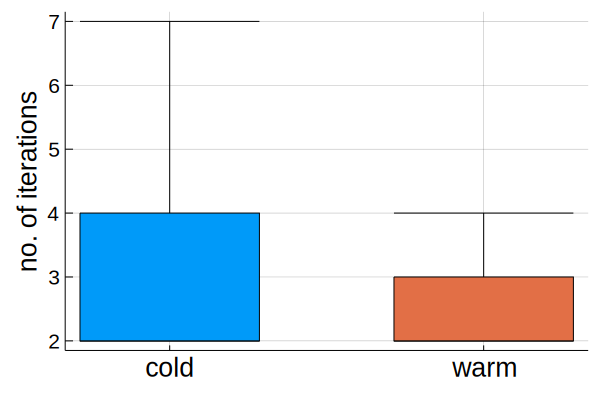

In [24]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_iter
diff_iter[:,2] = warm_iter
@show mean(cold_iter)
@show mean(warm_iter)
@show median(cold_iter)
@show median(warm_iter)

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


mean(diff_iter[:, 1]) = 2.570112536706927
mean(diff_iter[:, 2]) = 2.1493459158303727
size(diff_iter) = (1126, 2)


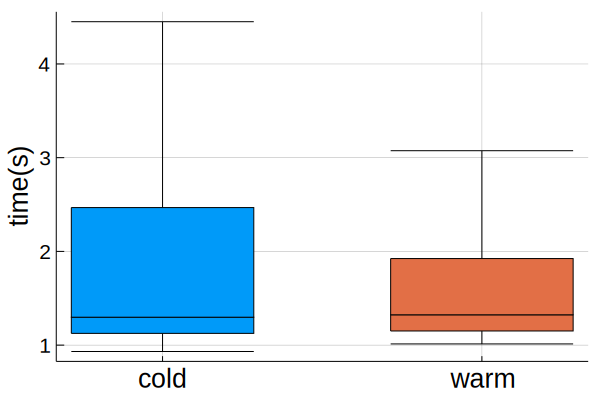

In [25]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_time
diff_iter[:,2] = warm_time
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="time(s)")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [26]:
diff_iter = cold_iter - warm_iter
count(x->x==0.0,diff_iter)
# count(x->x<0.0,diff_iter)

701

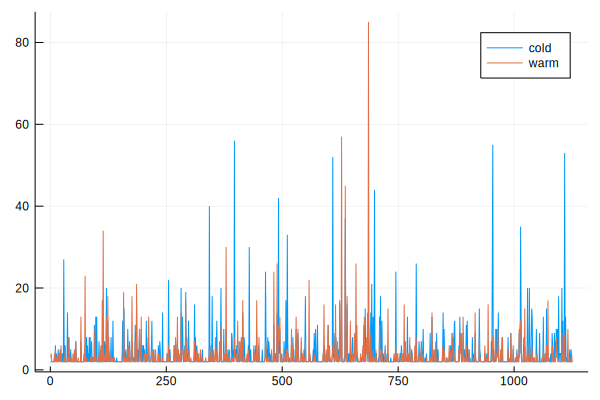

In [27]:
xs = 1:size(w_filt,1)
plot(xs, cold_iter,label="cold")
plot!(xs, warm_iter, label = "warm")


In [28]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (93, 3)
size(c_filt_large_iter) = (93, 3)


(93, 3)

mean(diff_iter[:, 1]) = 17.817204301075268
mean(diff_iter[:, 2]) = 8.978494623655914
median(diff_iter[:, 1]) = 14.0
median(diff_iter[:, 2]) = 5.0
size(diff_iter) = (93, 2)


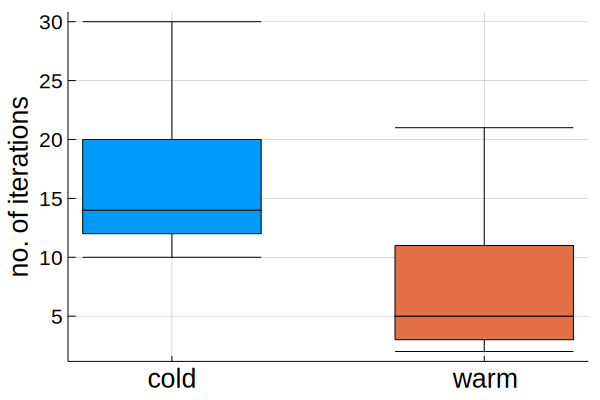

In [29]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [30]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (160, 3)
size(c_filt_large_iter) = (160, 3)


(160, 3)

mean(diff_iter[:, 1]) = 13.6875
mean(diff_iter[:, 2]) = 7.6625
median(diff_iter[:, 1]) = 10.5
median(diff_iter[:, 2]) = 5.0
size(diff_iter) = (160, 2)


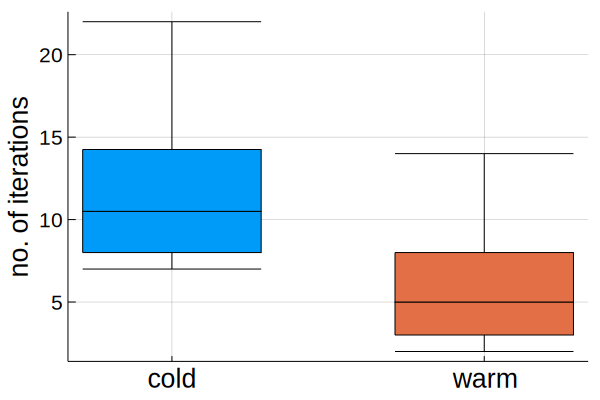

In [31]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [32]:
# Plot all three trajs

In [ ]:
paramsFileName = "PolyComboParams.h5"
row = 836
@show row
# For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
x_v_norm = X_valid_norm[row,:] # size 26
# First convert to X_valid
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:13]
x_final = x_v[14:26]
@show x_init
@show x_final
    
model = getModelWithTwoPolyObsOneAtCorner()
# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, true)
gusto_solve_time = (time_ns() - time_start)/10^9
@show isConverged
@show numIter
@show gusto_solve_time

In [ ]:
plot()
plot_env_and_trajs_three_comp(model, [X_all_true[end]])